# RNNs: How To Implement A Basic RNN

### Read In, Clean, And Split The Data

In [1]:
# Read in data and split into training and test set
# NOTE: we are NOT cleaning the data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', 1000)

messages = pd.read_csv('../../../data/spam.csv', encoding='latin-1')
messages = messages.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
messages.columns = ["label", "text"]
labels = np.where(messages['label']=='spam', 1, 0)

X_train, X_test, y_train, y_test = train_test_split(messages['text'],
                                                    labels, test_size=0.2)

### Prep Data For Modeling

In [4]:
# Install keras
!pip install -U keras
!pip install -U tensorflow-cpu

     |████████████████████████████████| 144.1 MB 2.4 MB/s eta 0:00:01   |▋                               | 2.7 MB 1.3 MB/s eta 0:01:46     |▊                               | 3.3 MB 1.3 MB/s eta 0:01:45     |▊                               | 3.4 MB 1.3 MB/s eta 0:01:45     |▉                               | 3.7 MB 1.3 MB/s eta 0:01:45     |█▋                              | 7.5 MB 905 kB/s eta 0:02:31     |███                             | 13.6 MB 4.8 MB/s eta 0:00:28     |████▌                           | 20.4 MB 3.1 MB/s eta 0:00:40     |██████                          | 26.7 MB 2.8 MB/s eta 0:00:42     |██████▍                         | 29.0 MB 2.7 MB/s eta 0:00:43     |███████▋                        | 34.1 MB 2.6 MB/s eta 0:00:43     |███████▋                        | 34.3 MB 2.6 MB/s eta 0:00:43     |████████▏                       | 36.8 MB 1.2 MB/s eta 0:01:29     |████████▎                       | 37.2 MB 1.2 MB/s eta 0:01:29     |█████████                       | 40.4 MB 2.0 MB

Using legacy 'setup.py install' for termcolor, since package 'wheel' is not installed.
  Attempting uninstall: setuptools
    Found existing installation: setuptools 40.6.2
    Uninstalling setuptools-40.6.2:
      Successfully uninstalled setuptools-40.6.2
    Running setup.py install for termcolor ... done
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.16.1 requires jedi>=0.10, which is not installed.


In [5]:
# Import the tools we will need from keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [6]:
# Initialize and fit the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [7]:
# Use that tokenizer to transform the text messages in the training and test sets
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [10]:
# What do these sequences look like?
X_train_seq[0]

[32, 429, 2003, 759, 1034, 1288]

In [12]:
# Pad the sequences so each sequence is the same length
X_train_seq_padded=pad_sequences(X_train_seq,50)
X_test_seq_padded=pad_sequences(X_test_seq,50)

In [13]:
# What do these padded sequences look like?
X_train_seq_padded[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
         32,  429, 2003,  759, 1034, 1288], dtype=int32)

### Build Model

In [14]:
# Import the tools needed from keras and define functions to calculate recall and precision
import keras.backend as K
from keras.layers import Dense, Embedding, LSTM
from keras.models import Sequential

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [16]:
# Construct a simple RNN model
model = Sequential()

model.add(Embedding(len(tokenizer.index_word) + 1,32))
model.add(LSTM(32, dropout=0,recurrent_dropout=0))
model.add(Dense(32, activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          254336    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 263,745
Trainable params: 263,745
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m])

In [18]:
# Fit the RNN model
history = model.fit(X_train_seq_padded, y_train, 
                    batch_size=32, epochs=10,
                    validation_data=(X_test_seq_padded, y_test))

Epoch 1/10
140/140 [==============================] - 7s 27ms/step - loss: 0.4069 - accuracy: 0.8780 - precision_m: 0.1825 - recall_m: 0.1340 - val_loss: 0.0673 - val_accuracy: 0.9821 - val_precision_m: 0.9800 - val_recall_m: 0.8981
Epoch 2/10
140/140 [==============================] - 4s 26ms/step - loss: 0.0460 - accuracy: 0.9881 - precision_m: 0.9674 - recall_m: 0.9551 - val_loss: 0.0536 - val_accuracy: 0.9848 - val_precision_m: 0.9776 - val_recall_m: 0.9224
Epoch 3/10
140/140 [==============================] - 3s 22ms/step - loss: 0.0090 - accuracy: 0.9975 - precision_m: 0.9765 - recall_m: 0.9653 - val_loss: 0.0576 - val_accuracy: 0.9857 - val_precision_m: 0.9757 - val_recall_m: 0.9295
Epoch 4/10
140/140 [==============================] - 3s 22ms/step - loss: 0.0041 - accuracy: 0.9991 - precision_m: 0.9798 - recall_m: 0.9749 - val_loss: 0.0647 - val_accuracy: 0.9830 - val_precision_m: 0.9871 - val_recall_m: 0.8964
Epoch 5/10
140/140 [==============================] - 3s 22ms/step -

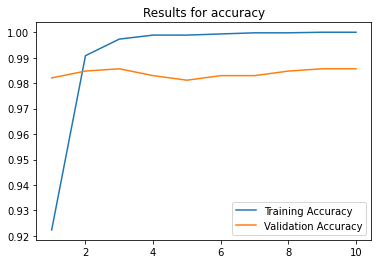

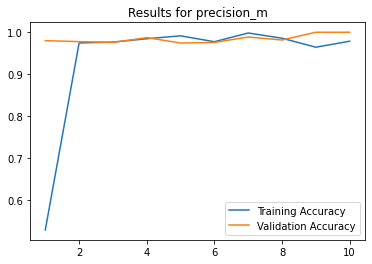

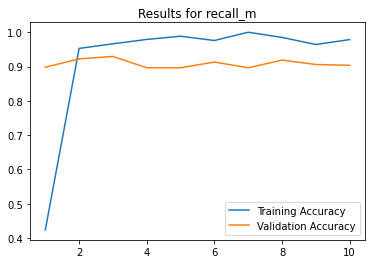

In [23]:
# Plot the evaluation metrics by each epoch for the model to see if we are over or underfitting
import matplotlib.pyplot as plt

for i in ['accuracy', 'precision_m', 'recall_m']:
    acc = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()